# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Loading the banana dataset from OpenML

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10, length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = sign.(y .- 0.5)

50-element Vector{Float64}:
  1.0
  1.0
 -1.0
  1.0
  1.0
 -1.0
  1.0
  1.0
  1.0
  1.0
  ⋮
 -1.0
  1.0
  1.0
 -1.0
 -1.0
  1.0
 -1.0
  1.0
  1.0

### We create a function to visualize the data

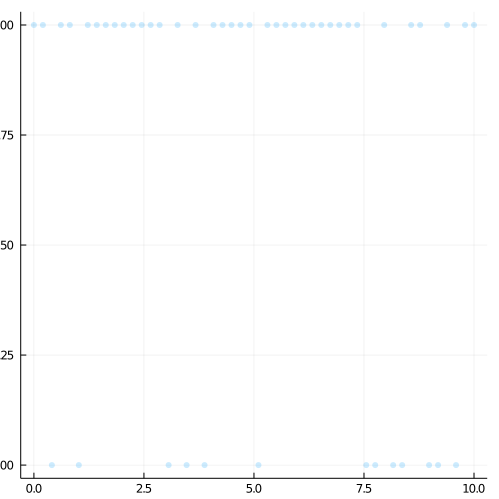

In [3]:
function plot_data(x, y; size=(300,500))
    Plots.scatter(x,
                y,
                alpha=0.2,
                markerstrokewidth=0.0,
                lab="",
                size=size
            )
end
plot_data(x, y; size = (500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign,
            kernel,
            LogisticLikelihood(),
            AnalyticVI(),
            optimiser = false
            )
@time train!(mfull, 5)

[ Info: Running full model
  0.695261 seconds (1.15 M allocations: 67.506 MiB, 99.42% compilation time)


### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y,
            kernel,
            LogisticLikelihood(),
            GibbsSampling(),
            optimiser = false
            )
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:29
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:47
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:51
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:23
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:06
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:55
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:47
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:41
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:36
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:32
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:29
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:27
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.07891272466230681, -0.14270286134046295, -0.18145409799314316, -0.10923289038321471, -0.002535251039771147, 0.2592446449512711, 0.5322754133775862, 0.8690643383328432, 1.185433227414574, 1.4545129658496547  …  -1.8020183509677519, -1.6913085020306813, -1.3886298392574978, -0.973326827406954, -0.48008698217580603, 0.01755605215024366, 0.5113172137051444, 0.8715405024904102, 1.1460986500905717, 1.2723158383818403]]
 [[0.7603030114433447, 0.936858256647337, 1.1322100982576022, 1.371789415798702, 1.6518573327247013, 2.0079081415275644, 2.3947655194435837, 2.690772033382806, 2.852600511461638, 2.8224017704631406  …  1.8313395335335376, 1.7931033284215336, 1.7086152277533695, 1.5516445118260382, 1.402368069148687, 1.2688184836915393, 1.1420681878705543, 1.0710935092174814, 1.00970804242419, 1.002306914088655]]
 [[0.6558422644111399, 0.5778277441368389, 0.6143339211789497, 0.6922481418065625, 0.9087803922595229, 1.200158841221031, 1.57459806

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

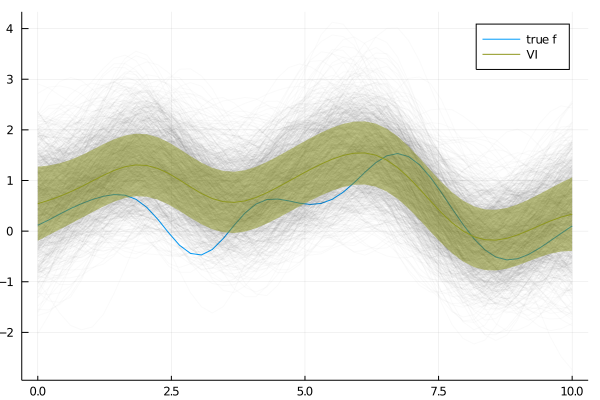

In [6]:
p1 = plot(x, f, label="true f")
plot!(x, samples, label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]), ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

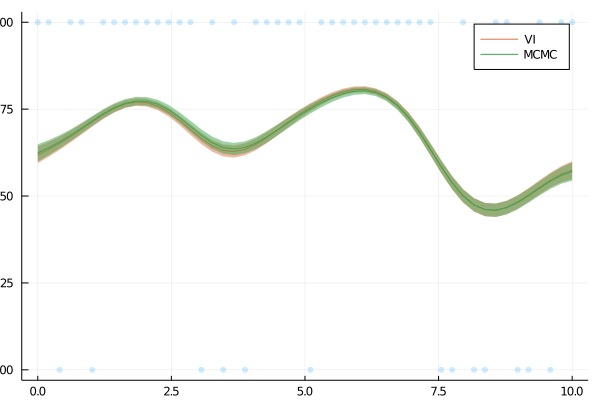

In [7]:
p2 = plot_data(x, y; size=(600,400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*